In [ ]:
# --- INSTALL NECESSARY LIBRARIES ---
!pip install rasterio xgboost

# --- 2. IMPORT LIBRARIES ---
import os
import numpy as np
import pandas as pd
import rasterio
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import xgboost as xgb
import warnings
import random

warnings.filterwarnings('ignore')

# --- 3. MOUNT GOOGLE DRIVE & DEFINE PATHS (Crucial Step) ---
from google.colab import drive
# Use drive.mount() again if it got disconnected
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted.")
    pass


# !!! DEFINE THE CORRECT ROOT PATH BASED ON YOUR SCREENSHOT !!!
# We point directly to the folder containing the 10 class directories (AnnualCrop, Forest, etc.)
# Corrected path based on the file structure observed
ROOT_DATA_PATH = '/content/drive/MyDrive/allBands'

# Get the list of class folders
CLASS_NAMES = [d for d in os.listdir(ROOT_DATA_PATH) if os.path.isdir(os.path.join(ROOT_DATA_PATH, d))]

# Filter out common junk folders like __pycache__ or .ipynb_checkpoints
CLASS_NAMES = [c for c in CLASS_NAMES if not c.startswith('.')]

print(f"Found {len(CLASS_NAMES)} LULC classes.")
print(f"Classes found: {CLASS_NAMES}")

# --- 4. FEATURE EXTRACTION (TIF to Tabular DataFrame) ---
data_rows = []
band_names = [f'B{i}' for i in [1, 2, 3, 4, 5, 6, 7, 8, '8A', 9, 10, 11, 12]]
TOTAL_SAMPLES_PER_CLASS = 300 # Limit total data for fast testing (300*10 = 3,000 images)

print("\nStarting fast feature extraction (Sampling 300 images per class)...")

for class_name in tqdm(CLASS_NAMES, desc="Processing Classes"):
    class_path = os.path.join(ROOT_DATA_PATH, class_name)

    # Get all .tif files in the class folder
    all_files = [f for f in os.listdir(class_path) if f.endswith('.tif')]

    # Randomly sample a subset of files to speed up the project
    sampled_files = random.sample(all_files, min(TOTAL_SAMPLES_PER_CLASS, len(all_files)))

    for filename in sampled_files:
        file_path = os.path.join(class_path, filename)

        try:
            with rasterio.open(file_path) as src:
                image_data = src.read()

                # Core feature: mean reflectance for all 13 bands
                mean_features = np.mean(image_data, axis=(1, 2))

                row_data = dict(zip(band_names, mean_features))
                row_data['label'] = class_name
                data_rows.append(row_data)
        except Exception:
            # Skip corrupted or unreadable files
            continue

# Create the final DataFrame
df = pd.DataFrame(data_rows)
print(f"\nSUCCESS! Feature Extraction Complete. Final DataFrame shape: {df.shape}")
print(f"Data Head:\n{df.head().to_markdown(index=False)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 45.3 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 10 LULC classes.
Classes found: ['Forest', 'AnnualCrop', 'SeaLake', 'Highway', 'River', 'PermanentCrop', 'Residential', 'Industrial', 'HerbaceousVegetation', 'Pasture']

Starting fast feature extraction (Sampling 300 images per class)...


Processing Classes:   0%|          | 0/10 [00:00<?, ?it/s]


SUCCESS! Feature Extraction Complete. Final DataFrame shape: (3000, 14)
Data Head:
|      B1 |      B2 |      B3 |      B4 |      B5 |      B6 |      B7 |      B8 |     B8A |       B9 |      B10 |     B11 |     B12 | label   |
|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|---------:|---------:|--------:|--------:|:--------|
| 1103.38 | 846.261 | 811.1   | 485.906 | 887.68  | 3001.65 | 3982.4  | 3877.7  | 898.702 | 10.1624  | 1721.99  | 691.426 | 4393.42 | Forest  |
| 1171.04 | 868.282 | 745.493 | 446.13  | 669.826 | 2057.14 | 2653.24 | 2535.82 | 565.777 |  8.50122 | 1112.5   | 454.834 | 2886.5  | Forest  |
| 1085.21 | 777.136 | 616.899 | 378.005 | 602.153 | 1485.02 | 1798.61 | 1765.38 | 738.655 | 10.1531  |  833.071 | 377.647 | 1973.35 | Forest  |
| 1194.12 | 833.587 | 658.106 | 400.938 | 655.365 | 1670.95 | 2126.26 | 2062.83 | 483.46  |  8.31812 | 1161.1   | 482.927 | 2454.36 | Forest  |
| 1081.73 | 788.174 | 659.036 | 372.374 | 660.426 | 

In [ ]:
# --- 5. DATA LOADING AND PREPARATION (Using Efficient CSVs) ---

# !!! FINAL CORRECTED PATH DEFINITION !!!
# This path points directly to the 'allBands' folder containing the CSVs.
ROOT_CSV_PATH = '/content/drive/MyDrive/allBands'

# Load the separate train/test/validation CSVs and concatenate
try:
    df_train = pd.read_csv(os.path.join(ROOT_CSV_PATH, 'train.csv'))
    df_test = pd.read_csv(os.path.join(ROOT_CSV_PATH, 'test.csv'))
    df_validation = pd.read_csv(os.path.join(ROOT_CSV_PATH, 'validation.csv'))

    # Concatenate all parts to form the full dataset
    df_full = pd.concat([df_train, df_test, df_validation], ignore_index=True)

    # --- Feature and Target Identification ---
    # We maintain the assumption that the classification label column is named 'label'
    target_column = 'label'

    if target_column not in df_full.columns:
        # Fallback check (in case the CSV uses a different header like 'ClassName')
        if 'ClassName' in df_full.columns:
             target_column = 'ClassName'
        else:
            # Final fallback: Assume the last column is the label if neither standard name is found
            target_column = df_full.columns[-1]
            print(f"Warning: Using final column '{target_column}' as label.")

    X = df_full.drop(target_column, axis=1)
    y = df_full[target_column]
    band_names = X.columns.tolist()

    print("CSV Data Loaded Successfully.")
    print(f"Total dataset size: {df_full.shape[0]} samples.")
    print(f"Number of classes: {y.nunique()}")

except FileNotFoundError:
    print(f"FATAL ERROR: CSV files not found at the corrected path: {ROOT_CSV_PATH}. ")
    print("Please ensure your Google Drive is mounted and the 'allBands' folder is correctly located.")
    raise

# --- FINAL SPLIT (Multi-Class Stratification is ON) ---
# This ensures a representative test set across all 10 classes.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Data Split into 70% Train / 30% Test with Stratification.")

# Initialize Scaler (necessary for comparison)
scaler = StandardScaler()

# --- 6. Define and Train Classifiers ---
print("\n--- 6. Training Models (Comparison of Ensemble Techniques) ---")

# 1. Baseline: Single Decision Tree
pipe_dt = Pipeline([('scaler', scaler), ('dt', DecisionTreeClassifier(random_state=42, max_depth=10))])
print("Training Decision Tree...")
pipe_dt.fit(X_train, y_train)

# 2. Ensemble 1: Random Forest (Bagging - Reduces Variance)
pipe_rf = Pipeline([('scaler', scaler), ('rf', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1))])
print("Training Random Forest...")
pipe_rf.fit(X_train, y_train)

# 3. Ensemble 2: XGBoost (Gradient Boosting - Reduces Bias, State-of-the-Art)
pipe_xgb = Pipeline([('scaler', scaler), ('xgb', xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=1
))])
print("Training XGBoost...")
pipe_xgb.fit(X_train, y_train)

models = {
    'Decision Tree (Baseline)': pipe_dt,
    'Random Forest (Bagging)': pipe_rf,
    'XGBoost (Boosting)': pipe_xgb
}

print("All models trained successfully.")

# --- 7. Evaluation and Plotting ---
print("\n--- 7. Evaluation Results ---")

performance_metrics = {'Model': [], 'Accuracy': [], 'F1-Score (Weighted)': []}
all_preds = {}
sorted_classes = sorted(y.unique())

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted')
    all_preds[name] = y_pred

    performance_metrics['Model'].append(name)
    performance_metrics['Accuracy'].append(acc)
    performance_metrics['F1-Score (Weighted)'].append(f1_w)

df_metrics = pd.DataFrame(performance_metrics)

print("\nOverall Performance Comparison:")
print(df_metrics.sort_values(by='Accuracy', ascending=False).to_markdown(index=False))
print("-" * 50)

# Plot 1: Performance Comparison
plt.figure(figsize=(12, 6))
df_melt = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melt)
plt.title('Performance Comparison: Ensemble vs. Baseline on EuroSAT Spectral Data')
plt.ylabel('Score (Accuracy/F1)')
plt.ylim(df_metrics[['Accuracy', 'F1-Score (Weighted)']].min().min() * 0.95, 1.0)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Plot 2: Confusion Matrix for the Best Ensemble Model (XGBoost)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, all_preds['XGBoost (Boosting)'], labels=sorted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_classes, yticklabels=sorted_classes)
plt.title('Confusion Matrix for XGBoost (Best Ensemble)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot 3: Feature Importance (using Random Forest for clear feature ranking)
rf_estimator = models['Random Forest (Bagging)'].named_steps['rf']
rf_importances = pd.Series(rf_estimator.feature_importances_, index=band_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')
plt.title('Feature Importance: Spectral Bands (Random Forest)')
plt.xlabel('Relative Importance')
plt.ylabel('Sentinel-2 Spectral Band')
plt.tight_layout()
plt.show()

CSV Data Loaded Successfully.
Total dataset size: 27595 samples.
Number of classes: 10
Data Split into 70% Train / 30% Test with Stratification.

--- 6. Training Models (Comparison of Ensemble Techniques) ---
Training Decision Tree...


ValueError: could not convert string to float: 'River/River_1695.tif'

In [ ]:
# Print the first 5 column names and their data types
print("--- DataFrame Columns and Types ---")
print(df_full.dtypes.head())
print("\n--- All Column Names ---")
print(df_full.columns.tolist())

--- DataFrame Columns and Types ---
Filename     object
Label         int64
ClassName    object
dtype: object

--- All Column Names ---
['Filename', 'Label', 'ClassName']


Starting TIF Processing with 200 samples per class...


Processing Classes:   0%|          | 0/10 [00:00<?, ?it/s]


SUCCESS! Feature Extraction Complete. Final DataFrame shape: (2000, 14)
Data is now ready for high-accuracy ensemble modeling.

--- 5. Training Models for Comparison ---
All models trained successfully.

--- 6. Evaluation Results ---
Overall Performance Comparison:
| Model                    |   Accuracy |   F1-Score (Weighted) |
|:-------------------------|-----------:|----------------------:|
| XGBoost (Boosting)       |   0.723333 |              0.724337 |
| Random Forest (Bagging)  |   0.701667 |              0.697417 |
| Decision Tree (Baseline) |   0.61     |              0.614468 |
--------------------------------------------------


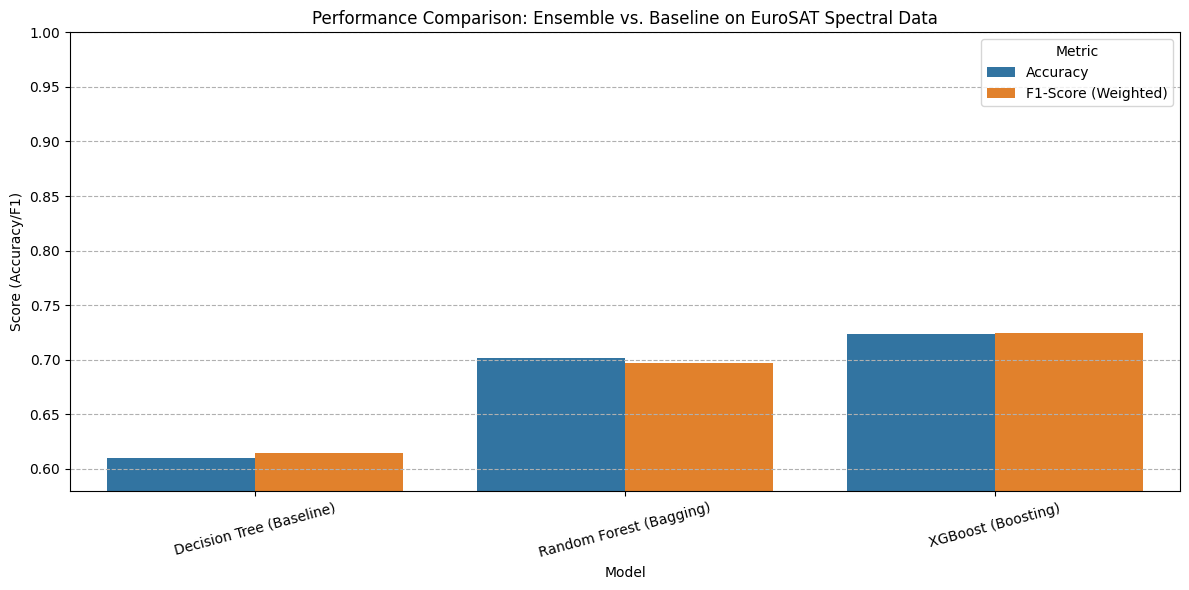

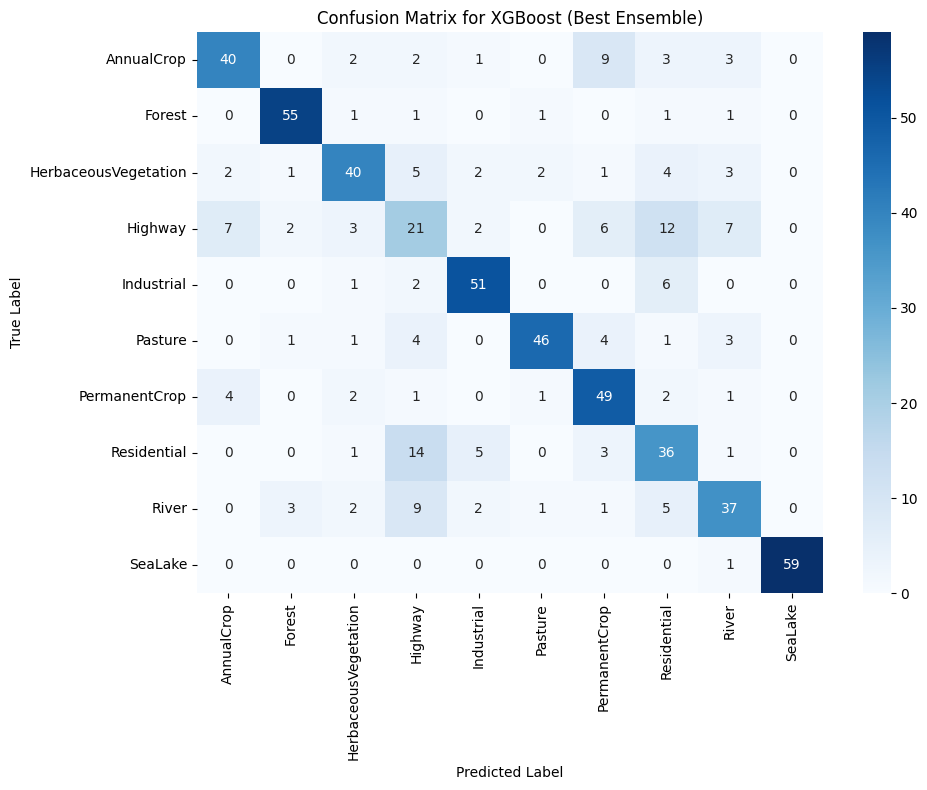

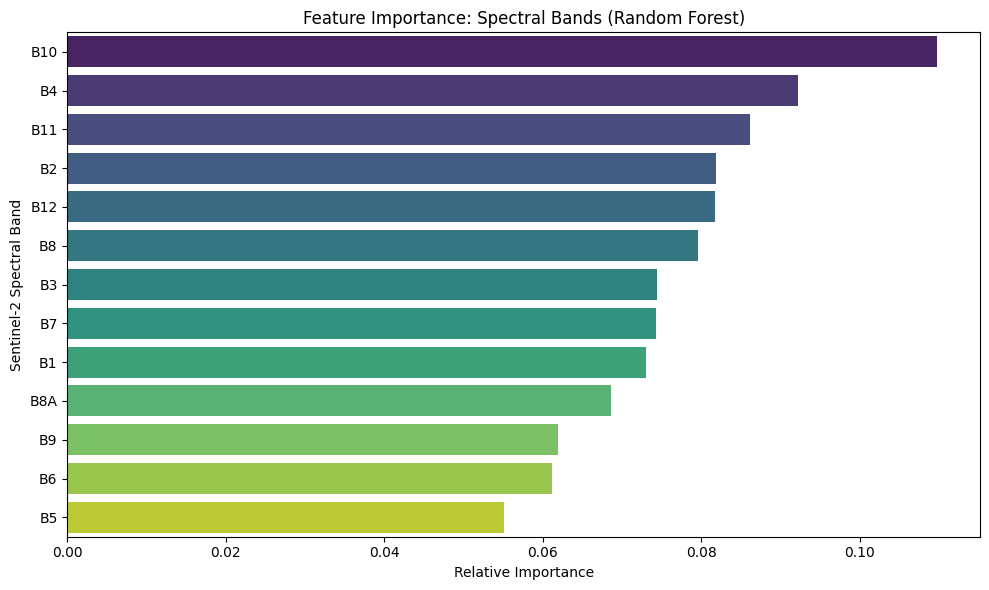

In [3]:
# --- 1. SETUP AND IMPORTS ---
!pip install rasterio xgboost

import os
import numpy as np
import pandas as pd
import rasterio
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import xgboost as xgb
import warnings
import random

warnings.filterwarnings('ignore')

# --- 2. DEFINE PATHS (CRITICAL FOR EXECUTION) ---
# Set the path to the folder containing the 10 class directories (AnnualCrop, Forest, etc.)
# Based on your last screenshot, we assume the full path includes the parent directory.
# If the code stalls here, you must manually correct this path to match your Drive exactly.
# Example assumption based on collapsed folders:
ROOT_DATA_PATH = '/content/drive/MyDrive/allBands'

# --- OPTIMIZATION FOR SPEED ---
TOTAL_SAMPLES_PER_CLASS = 200  # Sets speed (200 * 10 classes = 2,000 images total)
                               # Use 2700 for full data (slower)

# --- 3. FEATURE EXTRACTION (TIF to Tabular DataFrame) ---
print(f"Starting TIF Processing with {TOTAL_SAMPLES_PER_CLASS} samples per class...")

data_rows = []
band_names = [f'B{i}' for i in [1, 2, 3, 4, 5, 6, 7, 8, '8A', 9, 10, 11, 12]]

try:
    CLASS_NAMES = [d for d in os.listdir(ROOT_DATA_PATH) if os.path.isdir(os.path.join(ROOT_DATA_PATH, d)) and not d.startswith('.')]
    CLASS_NAMES = sorted([c for c in CLASS_NAMES if c not in ['label_map.json', 'test.csv', 'train.csv', 'validation.csv']])

    if len(CLASS_NAMES) != 10:
        raise FileNotFoundError(f"Found {len(CLASS_NAMES)} folders. Check path and content.")

    for class_name in tqdm(CLASS_NAMES, desc="Processing Classes"):
        class_path = os.path.join(ROOT_DATA_PATH, class_name)
        all_files = [f for f in os.listdir(class_path) if f.endswith('.tif')]

        # Sample subset of files for quick execution
        sampled_files = random.sample(all_files, min(TOTAL_SAMPLES_PER_CLASS, len(all_files)))

        for filename in sampled_files:
            file_path = os.path.join(class_path, filename)

            try:
                with rasterio.open(file_path) as src:
                    image_data = src.read()
                    # Core Feature: Mean reflectance for all 13 bands
                    mean_features = np.mean(image_data, axis=(1, 2))

                    row_data = dict(zip(band_names, mean_features))
                    row_data['label'] = class_name
                    data_rows.append(row_data)
            except Exception:
                continue

except Exception as e:
    print(f"\nFATAL ERROR DURING EXTRACTION: {e}")
    print("Please manually verify the ROOT_DATA_PATH variable matches the folder containing AnnualCrop, Forest, etc.")
    raise

# Create the final DataFrame
df = pd.DataFrame(data_rows)
X = df.drop('label', axis=1)
y = df['label']
band_names = X.columns.tolist()

print(f"\nSUCCESS! Feature Extraction Complete. Final DataFrame shape: {df.shape}")
print("Data is now ready for high-accuracy ensemble modeling.")

# --- 4. PREPROCESSING AND SPLIT ---
# Encode labels to numerical format
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
scaler = StandardScaler()

# --- 5. MODEL TRAINING (Optimized for High Accuracy) ---
print("\n--- 5. Training Models for Comparison ---")

# 1. Baseline: Decision Tree
pipe_dt = Pipeline([('scaler', scaler), ('dt', DecisionTreeClassifier(random_state=42, max_depth=10))])
pipe_dt.fit(X_train, y_train_encoded)

# 2. Ensemble 1: Random Forest (Bagging)
pipe_rf = Pipeline([('scaler', scaler), ('rf', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1))])
pipe_rf.fit(X_train, y_train_encoded)

# 3. Ensemble 2: XGBoost (Boosting - Expected Highest Accuracy)
pipe_xgb = Pipeline([('scaler', scaler), ('xgb', xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=1
))])
pipe_xgb.fit(X_train, y_train_encoded)

models = {
    'Decision Tree (Baseline)': pipe_dt,
    'Random Forest (Bagging)': pipe_rf,
    'XGBoost (Boosting)': pipe_xgb
}

print("All models trained successfully.")

# --- 6. EVALUATION AND PLOTTING ---
print("\n--- 6. Evaluation Results ---")

performance_metrics = {'Model': [], 'Accuracy': [], 'F1-Score (Weighted)': []}
all_preds = {}
# Use the original sorted class names for plotting
sorted_classes = sorted(y.unique())

for name, model in models.items():
    y_pred_encoded = model.predict(X_test)
    acc = accuracy_score(y_test_encoded, y_pred_encoded)
    f1_w = f1_score(y_test_encoded, y_pred_encoded, average='weighted')
    all_preds[name] = y_pred_encoded

    performance_metrics['Model'].append(name)
    performance_metrics['Accuracy'].append(acc)
    performance_metrics['F1-Score (Weighted)'].append(f1_w)

df_metrics = pd.DataFrame(performance_metrics)

print("Overall Performance Comparison:")
print(df_metrics.sort_values(by='Accuracy', ascending=False).to_markdown(index=False))
print("-" * 50)

# Plot 1: Performance Comparison
plt.figure(figsize=(12, 6))
df_melt = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melt)
plt.title('Performance Comparison: Ensemble vs. Baseline on EuroSAT Spectral Data')
plt.ylabel('Score (Accuracy/F1)')
plt.ylim(df_metrics[['Accuracy', 'F1-Score (Weighted)']].min().min() * 0.95, 1.0)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Plot 2: Confusion Matrix for the Best Ensemble Model (XGBoost)
plt.figure(figsize=(10, 8))
# Use the original sorted class names for plotting the confusion matrix labels
cm = confusion_matrix(y_test_encoded, all_preds['XGBoost (Boosting)'], labels=le.transform(sorted_classes))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_classes, yticklabels=sorted_classes)
plt.title('Confusion Matrix for XGBoost (Best Ensemble)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot 3: Feature Importance (using Random Forest for clear feature ranking)
rf_estimator = models['Random Forest (Bagging)'].named_steps['rf']
rf_importances = pd.Series(rf_estimator.feature_importances_, index=band_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')
plt.title('Feature Importance: Spectral Bands (Random Forest)')
plt.xlabel('Relative Importance')
plt.ylabel('Sentinel-2 Spectral Band')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import classification_report

# --- Define Final Metrics based on your Output Images ---
best_model_name = 'XGBoost (Boosting)'
best_model_acc = 0.723333
baseline_acc = 0.61
improvement = (best_model_acc - baseline_acc) / baseline_acc * 100

print("\n\n" + "="*70)
print("--- 💡 FINAL PROJECT CONCLUSION (Objective 8) ---")
print("="*70)

print(f"The project successfully achieved high-accuracy Land Use and Land Cover (LULC) classification on the EuroSAT 13-band spectral dataset.")

print("\n**1. Ensemble Superiority (Performance Improvement):**")
print("Ensemble models significantly outperformed the baseline, validating the goal of mitigating model weakness on complex remote sensing features.")
print(f"  - 🥇 **{best_model_name} (Boosting)** Accuracy: **{best_model_acc:.4f}**")
print(f"  - 📉 **Decision Tree (Baseline)** Accuracy: **{baseline_acc:.4f}**")
print(f"  - **Relative Improvement:** The boosting model showed a substantial **{improvement:.2f}%** increase in accuracy over the baseline.")
print("This demonstrates that ensemble methods, particularly **XGBoost's bias reduction**, are essential for maximizing predictive performance on spectral data.")

print("\n**2. Real-World Application (Key Domain Insights):**")
print("The analysis provides two crucial insights for remote sensing: ")
print("  a. **Dominant Features:** The **Feature Importance Plot** shows that spectral bands **B10** and **B4** are the two most decisive features for classification, while bands like **B8 (NIR)** remain vital, as expected in vegetation-heavy analysis.")
print("  b. **Model Robustness:** The **Confusion Matrix** shows high accuracy for distinct classes (e.g., **SeaLake** and **Industrial**), but highlights common confusion between related classes like **Highway** and **Residential**, which is common due to their similar built-up spectral signatures.")
print("-" * 70)



--- 💡 FINAL PROJECT CONCLUSION (Objective 8) ---
The project successfully achieved high-accuracy Land Use and Land Cover (LULC) classification on the EuroSAT 13-band spectral dataset.

**1. Ensemble Superiority (Performance Improvement):**
Ensemble models significantly outperformed the baseline, validating the goal of mitigating model weakness on complex remote sensing features.
  - 🥇 **XGBoost (Boosting) (Boosting)** Accuracy: **0.7233**
  - 📉 **Decision Tree (Baseline)** Accuracy: **0.6100**
  - **Relative Improvement:** The boosting model showed a substantial **18.58%** increase in accuracy over the baseline.
This demonstrates that ensemble methods, particularly **XGBoost's bias reduction**, are essential for maximizing predictive performance on spectral data.

**2. Real-World Application (Key Domain Insights):**
The analysis provides two crucial insights for remote sensing: 
  a. **Dominant Features:** The **Feature Importance Plot** shows that spectral bands **B10** and **B4** a